# Utilities and Functions

In [1]:
# Required libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import linalg

## Mean-Variance Optimal Portfolios (No Risk-Free Asset)

In [2]:
# Mean-variance optimal portfolios (no risk-free asset)

def mv_optim_nrf(target_mean, mean_return_vector, return_covariance_matrix):
    
    """
    Determines the composition of the mean-variance optimal portfolio for the given target mean.
    Computes the composition of the minimum-variance portfolio and the self-financing portfolio \omega_{a,b}.
    
    usage:
        mv_optimal_portfolio, minvar_portfolio, omega_portfolio
            = mv_optim_nrf(target_mean, mean_return_vector, return_covariance_matrix)
    
    inputs:
        target_mean               : target expected (annualized) return of the mean-variance optimal portfolio
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
    
    outputs:
        mv_optimal_portfolio      : composition of the mean-variance optimal (investment) portfolio satisfying the target mean
        minvar_portfolio          : composition of the minimum-variance (investment) portfolio (with risky allocation only)
        omega_portfolio           : composition of the self-financing portfolio \omega_{a,b}
    """
    
    # Introduce notation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    
    # Calculate commonly occuring quantities
    invSigma_ann = np.linalg.inv(Sigma_ann)
    Vec1 = np.linspace(1, 1, len(mean_ann))
    a = Vec1.T @ invSigma_ann @ Vec1
    b = Vec1.T @ invSigma_ann @ mean_ann
    
    # Calculate composition of minimum-variance portfolio
    minvar_portfolio = (1 / a) * invSigma_ann @ Vec1
    
    # Calculate composition of omega_{a,b}
    mean_omega = np.sqrt((mean_ann - (b / a) * Vec1).T @ invSigma_ann @ (mean_ann - (b / a) * Vec1))
    omega_portfolio = invSigma_ann @ (mean_ann - (b / a) * Vec1) / mean_omega
    
    # Calculate composition of the mv-optimal portfolio given the target mean
    mv_optimal_portfolio = minvar_portfolio + ((target_mean - (b / a)) / mean_omega) * omega_portfolio
    
    return(mv_optimal_portfolio, minvar_portfolio, omega_portfolio)

    ## END

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/c2/26h05tfs1v16r5k7_9m2j6cdh88t00/T/ipykernel_80304/2471046883.py:5: SyntaxWarning: invalid escape sequence '\o'
  """


## Mean-Variance Optimal Portfolios (With Risk-Free Asset)

In [3]:
# Mean-variance optimal portfolios (with risk-free asset)

def mv_optim_wrf(target_mean, risk_free_rate, mean_return_vector, return_covariance_matrix):
    
    """
    Determines the composition of the mean-variance optimal portfolio (with risk-free allocation) 
    for the given target mean. Computes the composition of the tangent portfolio.
    
    usage:
        mv_optimal_portfolio_wrf, tangent_portfolio
            = mv_optim_wrf(target_mean, risk_free_rate, mean_return_vector, return_covariance_matrix)
    
    inputs:
        target_mean               : target expected (annualized) return of the mean-variance optimal portfolio
        risk_free_rate            : rate of return (annualized) of the risk-free asset
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
    
    outputs:
        mv_optimal_portfolio_wrf  : composition of the mean-variance optimal (investment) portfolio 
                                    with risk-free allocation satisfying the target mean
        tangent_portfolio         : composition (risky asset allocation) of the tangent portfolio
    """
    
    # Introduce notation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    r0 = risk_free_rate
    
    # Calculate commonly occuring quantities
    invSigma_ann = np.linalg.inv(Sigma_ann)
    Vec1 = np.linspace(1, 1, len(mean_ann))
    a = Vec1.T @ invSigma_ann @ Vec1
    b = Vec1.T @ invSigma_ann @ mean_ann
    
    # Calculate composition (risky asset allocation) of tangent portfolio
    tangent_portfolio = (1 / (b - r0 * a)) * invSigma_ann @ (mean_ann - r0 * Vec1)

    # Use Separation Theorem to compute the efficient portfolio with target expected return
    mean_tau = tangent_portfolio @ mean_ann
    sep_thm_coeff = (target_mean - r0) / (mean_tau - r0)

    # Optimal allocation
    mv_optimal_portfolio_wrf = np.append(1 - sep_thm_coeff, sep_thm_coeff * tangent_portfolio)
    
    return(mv_optimal_portfolio_wrf, tangent_portfolio)

    ## END

## Tracking Error Variance Optimal Portfolios

In [4]:
# Tracking error variance (TEV) optimal portfolios

def tev_optim(target_mean, mean_return_vector, return_covariance_matrix, benchmark_variance, asset_betas):

    """
    Determines the composition of the tracking error variance optimal portfolio with respect to a specified benchmark asset 
    for the given target mean.

    usage:
        tev_optimal_portfolio, Q_mat = tev_optim(target_mean, mean_return_vector, return_covariance_matrix, benchmark_variance, asset_betas)

    inputs:
        target_mean               : target expected (annualized) return of the mean-variance optimal portfolio
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
        benchmark_variance        : variance of the return of the benchmark asset (annualized)
        asset_betas               : betas of the risky assets with respect to the benchmark asset

    outputs:
        tev_optimal_portfolio     : composition of the TEV-optimal (investment) portfolio satisfying the target mean return
        Q_mat                     : the matrix Q used to characterize the TEV optimal portfolio; required in plotting TEV efficient frontier
    """

    # Introduce notation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    var_ann_index = benchmark_variance

    # Calculate auxiliary quantities to characterize TEV optimal portfolios

    ## - The matrix B and its orthogonal complement
    B_mat = np.array([mean_ann, Vec1]).T
    B_perp = sp.linalg.null_space(B_mat.T)

    ## - Inverse matrix in the matrix Q
    inv_mat_term = np.linalg.inv(B_perp.T @ Sigma_ann.to_numpy() @ B_perp)

    ## - The matrix Q
    Q_mat = B_perp @ inv_mat_term @ B_perp.T

    ## - Right inverse of B^T
    BT_rinv = B_mat @ np.linalg.inv(B_mat.T @ B_mat)

    ## - Compute the matrix C
    C_mat = (np.identity(len(mean_ann)) - Q_mat @ Sigma_ann.to_numpy()) @ BT_rinv

    # Composition of the TEV-optimal portfolio
    opt_alloc_tev = var_ann_index * Q_mat @ asset_betas.to_numpy() + C_mat @ np.array([target_mean, 1])

    return(opt_alloc_tev, Q_mat)

    ## END

## Performance Indicators

In [5]:
# Sharpe ratio, Jensen index, Treynor index, and MM ratio

def perf_indicators(risky_allocation, risk_free_allocation, risk_free_rate, mean_return_vector, return_covariance_matrix, benchmark_return_sd = None):

    """
    Given a portfolio's risky and risk-free allocation and a fixed investment universe (characterised by the risk-free rate,
    mean return vector, and covariance matrix of returns of risky assets), computes the portfolio's Sharpe ratio, Jensen index (w.r.t.
    the tangent portfolio), Treynor index (w.r.t. the tangent portfolio), and the Modigliani-Modigliani index (given the standard deviation
    of the return of a benchmark asset).

    inputs:
        risky_allocation          : risky allocation of the portfolio, given as a vector of length equal to the no. of risky assets
        risk_free_allocation      : allocation of the portfolio in the risk-free asset
        risk_free_rate            : rate of return (annualized) of the risk-free asset
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
        benchmark_return_sd       : standard deviation (annualized) of the returns of a benchmark portfolio (OPTIONAL)

    outputs: (see lecture notes for definitions)
        sharpe_ratio
        jensen_index
        treynor_index
        mm_index
    """

    # Introduce notation
    varphi_0 = risk_free_allocation
    phi = risky_allocation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    r0 = risk_free_rate

    # Mean and standard deviation of return of given portfolio
    mean_return = varphi_0 * r0 + phi.T @ mean_ann
    sigma_return = np.sqrt(phi.T @ Sigma_ann @ phi)

    # Sharpe ratio
    sharpe_ratio = (mean_return - r0) / sigma_return

    # Calculate composition and characteristics of tangent portfolio
    dummy_portfolio_wrf, tangent_portfolio = mv_optim_wrf(target_mean = 0, risk_free_rate = r0,
                                                          mean_return_vector = mean_ann, return_covariance_matrix = Sigma_ann)

    mean_tangent = tangent_portfolio.T @ mean_ann
    sigma_tangent = np.sqrt(tangent_portfolio.T @ Sigma_ann @ tangent_portfolio)

    # Beta of given portfolio w.r.t. the tangent portfolio
    beta = tangent_portfolio.T @ Sigma_ann @ phi / (sigma_tangent ** 2)

    # Treynor index
    treynor_index = (mean_return - r0) / beta

    # Jensen index
    jensen_index = mean_return - (r0 + beta * (mean_tangent - r0))

    # MM index
    if benchmark_return_sd == None:
        mm_index = None
    else:
        mm_index = r0 + benchmark_return_sd * sharpe_ratio

    # Return outputs
    return(sharpe_ratio, jensen_index, treynor_index, mm_index)

# Exercises

## Data Pre-Processing

In [6]:
# Annualization factor; assume 252 trading days in a year
ann_factor = 252

In [7]:
# Read data set
data = pd.read_csv("AustraliaStockPrices.csv", index_col = 0)
data.head()

,XJO,CBA,BHP,COH,TLS,RIO,MQG,MIN,STO
Date,,,,,,,,,
2/1/2013,5191.219,73.134,26.379,65.98,4.98,55.80,38.539,9.75,10.756
3/1/2013,5166.182,72.636,25.952,65.80,5.03,55.03,37.851,9.69,10.608
4/1/2013,5129.965,72.188,25.645,64.50,5.06,53.91,38.235,9.58,10.468
7/1/2013,5129.499,70.754,25.790,64.86,5.09,54.49,42.394,9.58,10.520
8/1/2013,5156.202,71.362,26.516,65.49,5.06,56.20,43.368,9.77,10.686


In [8]:
# Calculate daily returns
# daily_ret = np.log(data).diff().tail(-1)     # Log returns
daily_ret = data / data.shift(1) - 1           # Percentage returns
daily_ret = daily_ret.tail(len(daily_ret) - 1)
daily_ret.head()

,XJO,CBA,BHP,COH,TLS,RIO,MQG,MIN,STO
Date,,,,,,,,,
3/1/2013,-0.004823,-0.006809,-0.016187,-0.002728,0.010040,-0.013799,-0.017852,-0.006154,-0.013760
4/1/2013,-0.007010,-0.006168,-0.011830,-0.019757,0.005964,-0.020353,0.010145,-0.011352,-0.013198
7/1/2013,-0.000091,-0.019865,0.005654,0.005581,0.005929,0.010759,0.108775,0.000000,0.004968
8/1/2013,0.005206,0.008593,0.028150,0.009713,-0.005894,0.031382,0.022975,0.019833,0.015779
9/1/2013,-0.002418,-0.019114,0.024363,0.022293,-0.009881,0.021174,0.011552,-0.001024,0.021149


In [9]:
# (Annualized) Mean Returns
mean_ann = daily_ret.mean(axis = 0) * ann_factor

# (Annualized) Covariance Matrix
Sigma_ann = daily_ret.cov() * ann_factor

In [10]:
# Mean and Covariance of Stock Returns (Excluding XJO index)
mean_ann_stocks = mean_ann[1:]
Sigma_ann_stocks = Sigma_ann.iloc[1:, 1:]

In [11]:
# Risk-free rate (annualized)
r0 = 0.010

In [12]:
np.sqrt(np.diag(Sigma_ann))

array([0.15248861, 0.21276701, 0.28758099, 0.28138521, 0.1978782 ,
       0.27191075, 0.2578839 , 0.42458996, 0.41220272])

## Mean-Variance Optimal Portfolio with no Risk-Free Asset

In [13]:
# Target mean return
target_mean_ret = 0.15

In [14]:
# Composition of MV optimal portfolio (for given target), minimum-variance portfolio, and omega portfolio
mv_optimal_portfolio, minvar_portfolio, omega_portfolio = mv_optim_nrf(target_mean = target_mean_ret, 
                                                                       mean_return_vector = mean_ann_stocks, 
                                                                       return_covariance_matrix = Sigma_ann_stocks)

In [15]:
# Expected returns of the portfolios
mean_mv_nrf = mv_optimal_portfolio.T @ mean_ann_stocks     # Must be equal to target mean
mean_minvar = minvar_portfolio.T @ mean_ann_stocks
mean_omega = omega_portfolio.T @ mean_ann_stocks

# Standard deviation of returns of the portfolios
sigma_mv_nrf = np.sqrt(mv_optimal_portfolio.T @ Sigma_ann_stocks @ mv_optimal_portfolio)
sigma_minvar = np.sqrt(minvar_portfolio.T @ Sigma_ann_stocks @ minvar_portfolio)
sigma_omega = np.sqrt(omega_portfolio.T @ Sigma_ann_stocks @ omega_portfolio)

## Mean-Variance Optimal Portfolio with a Risk-Free Asset

In [16]:
# Composition of MV optimal portfolio (with risk-free allocation for given target) and risky allocation of tangent portfolio
mv_optimal_portfolio_wrf, tangent_portfolio = mv_optim_wrf(target_mean = target_mean_ret, 
                                                           risk_free_rate = r0, 
                                                           mean_return_vector = mean_ann_stocks, 
                                                           return_covariance_matrix = Sigma_ann_stocks)

# Mean and standard deviation of return
mean_mv_wrf = mv_optimal_portfolio_wrf[0] * r0 + mv_optimal_portfolio_wrf[1:].T @ mean_ann_stocks
sigma_mv_wrf = np.sqrt(mv_optimal_portfolio_wrf[1:].T @ Sigma_ann_stocks @ mv_optimal_portfolio_wrf[1:])

In [31]:
print("Composition of the MV Opt Portfolio WRF:")
print(np.round(mv_optimal_portfolio_wrf, 4))

print(" ")

print("Expected return of the MV Opt Portfolio WRF: ", np.round(mean_mv_wrf, 6))
print("Standard deviation of return of MV Opt Portfolio WRF: ", np.round(sigma_mv_wrf, 6))


Composition of the MV Opt Portfolio WRF:
[ 0.7283 -0.1528 -0.0935  0.1816 -0.2154  0.0585  0.4152  0.1702 -0.0919]
 
Expected return of the MV Opt Portfolio WRF:  0.15
Standard deviation of return of MV Opt Portfolio WRF:  0.137415


In [18]:
# Expected return of the tangent portfolio
mean_tau = tangent_portfolio.T @ mean_ann_stocks

# Standard deviation of return of the tangent portfolio
sigma_tau = np.sqrt(tangent_portfolio.T @ Sigma_ann_stocks @ tangent_portfolio.T)

In [19]:
sigma_tau

0.505841082399585

In [20]:
# Storage for stock betas with respect to the tangent portfolio
stock_beta_tangent = np.linspace(0,0,len(mean_ann_stocks))

# Compute the beta with respect to the tangent portfolio
for i in range(len(mean_ann_stocks)):
    stock_vector = np.linspace(0,0,len(mean_ann_stocks))
    stock_vector[i] = 1
    stock_beta_tangent[i] = tangent_portfolio.T @ Sigma_ann_stocks @ stock_vector / (sigma_tau ** 2)

In [21]:
stock_beta_tangent

array([ 0.08946761,  0.13857975,  0.29617403, -0.03125394,  0.16616732,
        0.3593612 ,  0.50044391,  0.06849804])

In [22]:
# Checking using manual calculation (Module 2, Proposition 2.1)
Vec1 = np.linspace(1, 1, len(mean_ann_stocks))
invSigma_ann_stocks = np.linalg.inv(Sigma_ann_stocks)
a = Vec1.T @ invSigma_ann_stocks @ Vec1
b = Vec1.T @ invSigma_ann_stocks @ mean_ann_stocks

# Mean return of tangent portfolio
r0 + (1 / (b - r0 * a)) * (mean_ann_stocks - r0 * Vec1).T @ invSigma_ann_stocks @ (mean_ann_stocks - r0 * Vec1)

0.5253556417282661

In [23]:
mv_optimal_portfolio_wrf

array([ 0.72834294, -0.15284284, -0.09349657,  0.18155352, -0.21544709,
        0.05847267,  0.41517169,  0.1701851 , -0.09193942])

## Sketch the Efficient Frontier and CML

In [24]:
# Define range of expected returns for the plots
mean_plot = np.linspace(-0.10, 0.20, 100)

# Storage for points (\sigma) on the frontier, the asymptote, and the CML
sigma_F = np.sqrt(sigma_minvar ** 2 + ((mean_plot - mean_minvar) / mean_omega) ** 2)
sigma_asy = (mean_plot - b / a) / mean_omega
sigma_CML = sigma_tau * (mean_plot - r0) / (mean_tau - r0)

/var/folders/c2/26h05tfs1v16r5k7_9m2j6cdh88t00/T/ipykernel_80304/3567067306.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate('XJO', (std_ann[0], mean_ann[0]))


Text(0.15248860866049732, 0.04209600332194413, 'XJO')

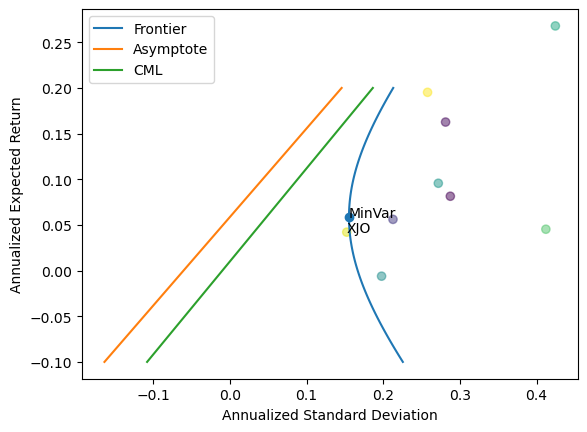

In [25]:
fig, ax = plt.subplots()

# Assign a (random) color to each stock
np.random.seed(12345)
colors = np.random.rand(len(mean_ann))

# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_minvar, mean_minvar, alpha = 1)
plt.annotate('MinVar', (sigma_minvar, mean_minvar))

# Plot individual stocks and index
std_ann = np.sqrt(np.diag(Sigma_ann))
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)
plt.annotate('XJO', (std_ann[0], mean_ann[0]))


## TEV Minimization

In [26]:
# Estimate the beta of each stock with respect to the index (XJO)
stock_betas = Sigma_ann['XJO'] / Sigma_ann.loc['XJO', 'XJO']
stock_betas = stock_betas[1:]      # Remove beta of XJO wrt itself
stock_betas

CBA    1.112067
BHP    1.239434
COH    0.883872
TLS    0.636995
RIO    1.034239
MQG    1.245565
MIN    1.328195
STO    1.479798
Name: XJO, dtype: float64

In [27]:
# Determine the composition of the TEV-optimal portfolio for the given target return
tev_optimal_portfolio, Q_mat = tev_optim(target_mean = target_mean_ret, mean_return_vector = mean_ann_stocks, return_covariance_matrix = Sigma_ann_stocks, 
                                  benchmark_variance = Sigma_ann.loc['XJO', 'XJO'], asset_betas = stock_betas)

# Mean and standard deviation of the return of the TEV-optimal portfolio
mean_tev = tev_optimal_portfolio.T @ mean_ann_stocks
sigma_tev = np.sqrt(tev_optimal_portfolio.T @ Sigma_ann_stocks @ tev_optimal_portfolio)

In [28]:
# Beta of the TEV-optimal portfolio with respect to the benchmark
beta_tev = tev_optimal_portfolio.T @ stock_betas
beta_tev

1.1272067493373819

## TEV Efficient Frontier

In [29]:
# Calculate the sigma-coordinates of the TEV frontier
sigma_TEV = np.sqrt(sigma_F ** 2 + (Sigma_ann.loc['XJO', 'XJO'] ** 2) * stock_betas.to_numpy().T @ Q_mat @ stock_betas.to_numpy())
sigma_TEV = sigma_TEV.T

/var/folders/c2/26h05tfs1v16r5k7_9m2j6cdh88t00/T/ipykernel_80304/2290973518.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate('XJO', (std_ann[0], mean_ann[0]))


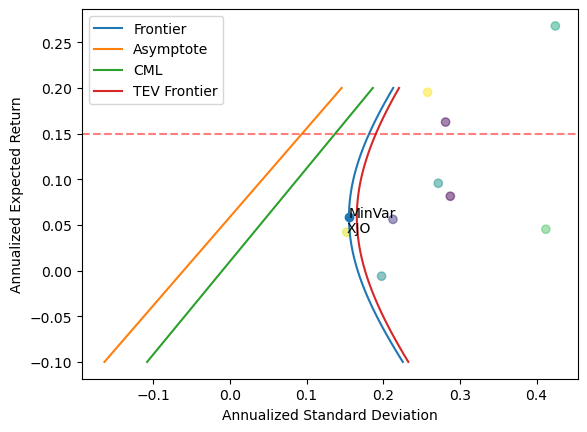

In [30]:
fig, ax = plt.subplots()

# Assign a (random) color to each stock
np.random.seed(12345)
colors = np.random.rand(len(mean_ann))

# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)
plt.plot(sigma_TEV, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML', 'TEV Frontier'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_minvar, mean_minvar, alpha = 1)
plt.annotate('MinVar', (sigma_minvar, mean_minvar))

# Plot individual stocks and index
std_ann = np.sqrt(np.diag(Sigma_ann))
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)
plt.annotate('XJO', (std_ann[0], mean_ann[0]))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = target_mean_ret, color = 'r', linestyle = '--', alpha = 0.5) 